# Activation analysis of fMRI data to study category representation in the human brain

## In this notebook, we will work through an activation analysis of one participant from Haxby et al. (2001)

The goal here is for you to learn about traditional fMRI analysis, which has typically analyzed which regions of the brain are more active for certain tasks compared to others. In this case, we will be looking at activations in the visual system in response to different categories of images (e.g., faces, houses). This analysis will be done on a single participant from a landmark study:

Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cotex. *Science*, 293, 2425-2430. http://dx.doi.org/10.1126/science.1063736

## Why are you having us analyze fMRI data in introductory cognitive neuroscience course?
I (Prof. Derek Huffman) believe that we learn best by actually working with the content from the field. For example, if you want to learn how to paint, sure, you can read a book about painting, you can look at paintings, you might even learn from watching videos of other people painting and lectures in which experienced artists teach you how to paint. However, you are going to learn best by actually picking up a paintbrush, dipping it in the paint, and trying to paint something yourself. You will learn how to mix colors together, how much pressure to apply to the canvas, which paintbrush to use in different situations, how long to let paint dry before adding different colors, and (perhaps most importantly) you will learn from your mistakes. Simply put, you will learn a lot more by practicing (as the saying goes: "experience is the best teacher"). Moreover, these practical experiences will help you learn more from your other resources. For example, you might revisit readings or discussions to really think about *why* we use certain techniques. Similarly, to *really* understand cognitive neuroscience, I believe that we have to actually practice some cognitive neuroscience, so pick up your paintbrush and start painting some brain maps with the Python code below!

## Attributions and citations for this notebook
Written by Professor Derek J. Huffman at Colby College, Waterville, ME 04901, USA (with the nilearn tutorials as a helpful starting point; Nilearn Contributors et al., 2023)

Most recent updates: 2024 JAN 18

Please keep the attribution line above as well as the citations below (update as you change the code):

Huffman, D. J. (2024). An in-depth exploration of the interplay between fMRI methods and theory in cognitive neuroscience. PsyArXiv.

Nilearn Contributors et al. (2023) nilearn. Available at: https://zenodo.org/record/8397156.

## Set things up for the analysis

### Load the relevant packages, etc.

#### For Google Colaboratory, we need to install nilearn onto the machines we are using (in the cloud).

In [ ]:
pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 15.3 MB/s eta 0:00:00


#### Now we can import the relevant functions for our analysis.


In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.datasets import fetch_haxby
from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.plotting import show
from nilearn.plotting import view_img

Note: the 'from nilearn.glm.first_level import FirstLevelModel' will throw a warning about nilearn.glm being experimental (AKA we are on the cutting edge haha), but we can ignore this for now.

### Gather the fMRI and event/behavioral/timing data

Next, we will want to get all of the data. Here, we will primarily rely on the fetch_haxby() function. This function will load data from a single participant (subj2) to the location we set for datapath below.

#### First, define a variable with the path to the data:

In [ ]:
datapath = '.'

#### Then, use the fetch_haxby function to load the data:
Note: here we give the function the input of the datapath to let it know where to find the data.

In [ ]:
subject_data = fetch_haxby(datapath)


Dataset created in ./haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 254541824 of 291168628 bytes (87.4%,    0.6s remaining) ...done. (5 seconds, 0 min)
Extracting data from ./haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz..... done.


Now we can take a look at the subject_data.

In [ ]:
subject_data

{'anat': ['./haxby2001/subj2/anat.nii.gz'],
 'func': ['./haxby2001/subj2/bold.nii.gz'],
 'session_target': ['./haxby2001/subj2/labels.txt'],
 'mask_vt': ['./haxby2001/subj2/mask4_vt.nii.gz'],
 'mask_face': ['./haxby2001/subj2/mask8b_face_vt.nii.gz'],
 'mask_house': ['./haxby2001/subj2/mask8b_house_vt.nii.gz'],
 'mask_face_little': ['./haxby2001/subj2/mask8_face_vt.nii.gz'],
 'mask_house_little': ['./haxby2001/subj2/mask8_house_vt.nii.gz'],
 'mask': './haxby2001/mask.nii.gz',
 'description': 'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distributed and overlapping\nresponse patterns.\n\nContent\n-------\nThe "simple" dataset includes\n    :\'func\': Nifti images with bold data\n    :\'session_target\': Text file containing session data\n    :\'mask\': Nifti images with employed mask\n    :\'ses

Note: the output above is a dictionary, where each key of the dictionary is a given file type and the value of each key is either a string or a list of strings, which indicate the locations of the various file types, etc.

Here, we will rename things for convenience (i.e., a specific name for anat and fmri files). We also will mask our data to the ventral temporal lobe (here, called: mask_img), which is known to play a key role in high-level vision. Note: the [0] bit is required because these are in a list, so we use this syntax to extract the element of interest (even though there is only one element in these lists).

In [ ]:
anat = subject_data.anat[0]
fmri = load_img(subject_data.func[0])
mask_img = subject_data.mask_vt[0]

Gather the labels for each frame. These will be necessary for splitting up the fMRI data based on run (i.e., although the fMRI data were collected from 12 separate runs, they have been concatenated = combined into a single file). Here we will use the pandas function read_csv. Note: a CSV file (comma-separated values) is one way of saving data in a file where things are separated by commas. Here, the file is separated by blank spaces, hence the sep=' ' (i.e., notice the blank space between the quotes). This function will create a pandas DataFrame, which is a convenient way of storing this type of data. The DataFrame is similar to a numpy.array, but allows for data with different types in different columns. Similar to a dictionary, you can access the columns with the following syntax, e.g., tr_labels['labels']

In [ ]:
tr_labels = pd.read_csv(subject_data.session_target[0], sep=' ')
tr_runs = tr_labels['chunks']
tr_labels

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


Gather the event timing (onsets and durations), which we will use to set up our models (see below). The difference between tr_labels (above) and events (below) is that the former contains information about what is happening for each frame of the fMRI data while the latter shows the exact times (in seconds) at which different events happen.

NOTE WELL: before you run the following line of code, you need to get the events.csv file into Google Colaboratory's workspace. Here, the easiest way to do this is to click on the "Files" icon on the left side of the screen (looks like a folder), then drag and drop the events.csv file here. If you get an error on this line, then it probably means that you need to upload this file.

In [ ]:
events = pd.read_csv('%s/events.csv' % datapath)
events

,trial_type,run,onset,duration
0,scissors,0,12.0,24.0
1,face,0,48.0,24.0
2,cat,0,84.0,24.0
3,shoe,0,120.0,24.0
4,house,0,156.0,24.0
...,...,...,...,...
91,scrambledpix,11,120.0,24.0
92,face,11,156.0,24.0
93,shoe,11,192.0,24.0
94,cat,11,228.0,24.0


#### Extract the fMRI and event files into a list where the elements are the runs.

Now, we will want to separate the data based on the runs. Here, we will load the data into lists in which each element contains the data for one fMRI run.

Note: hopefully the [x for x in y] type of syntax is familar from the earlier homeworks/readings, but this is basically a way that you can populate a list with a for loop in a single line of code. Here, it will loop over all of the runs and separate the data into a list. We will end up with lists with 12 elements: fmri_runs will have 12 runs of fMRI data and events_runs will have 12 runs of events/behavioral/timing data.

In [ ]:
run_nums = np.unique(events['run'])

fmri_runs = [index_img(fmri, tr_runs == run_i) for run_i in run_nums]
events_runs = [events[events['run'] == run_i] for run_i in run_nums]

## Now we need to set up our activation model: the GLM

### First, let's define some variables of interest.

First, we will provide some parameters that attempt to attenuate low-frequency drift, which is common in fMRI data and would contribute noise if we do not try to account for it. We will use a polynomial drift model with drift order of 3. We will also high-pass filter the data.

In [ ]:
drift_model = 'polynomial'
poly_drift_order = 3
high_pass = 0.01  #0.001

### Specify and fit the model

In [ ]:
fmri_glm = FirstLevelModel(t_r=2.5, noise_model='ar1', standardize=False,
                           hrf_model='spm', drift_model=drift_model,
                           drift_order=poly_drift_order, high_pass=high_pass,
                           mask_img=mask_img)

fmri_glm = fmri_glm.fit(fmri_runs, events_runs)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(
/usr/local/lib

### Show the design matrices for each run

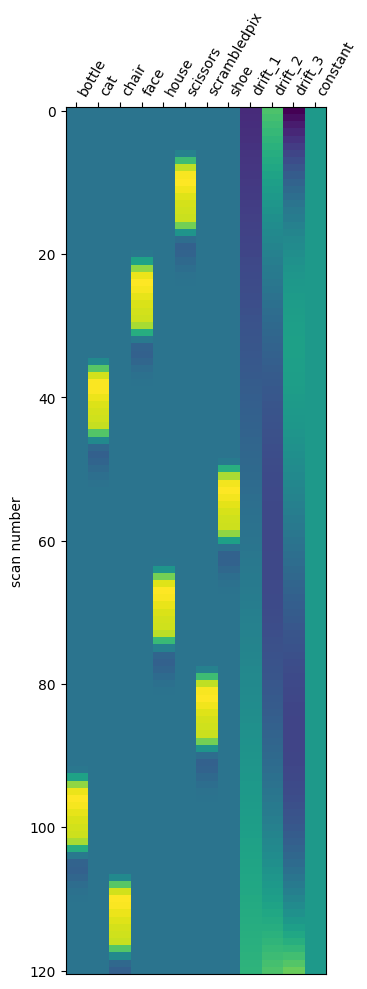

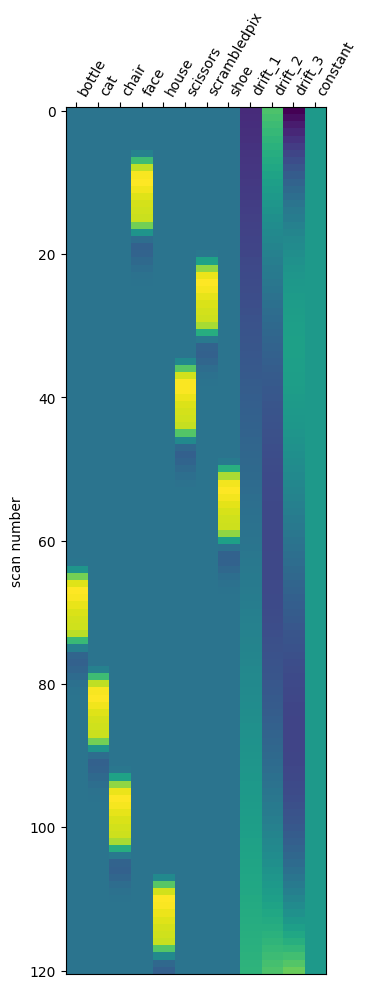

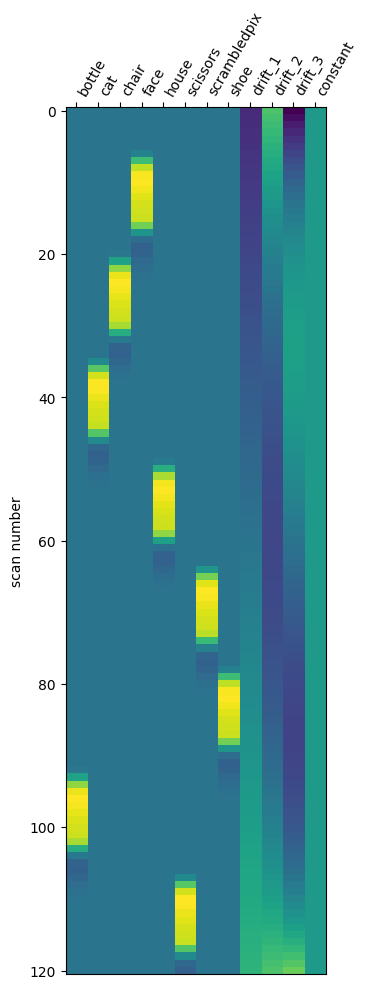

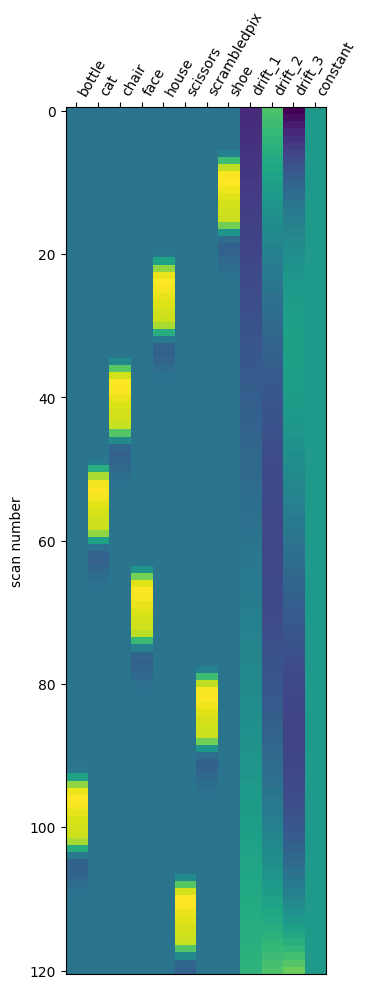

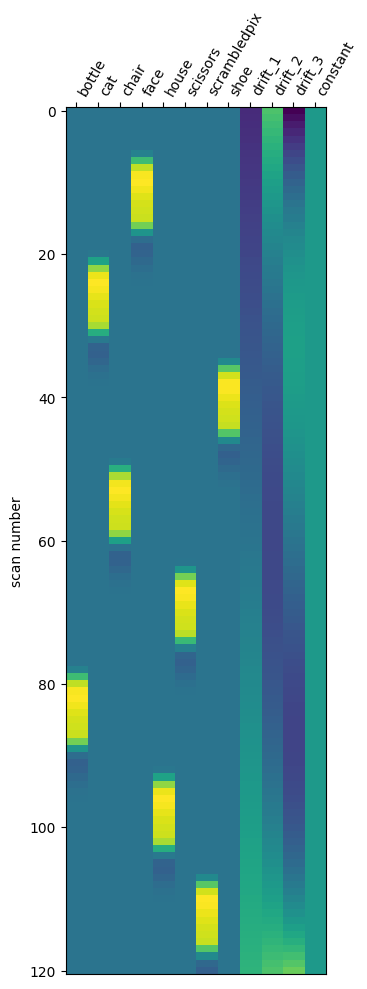

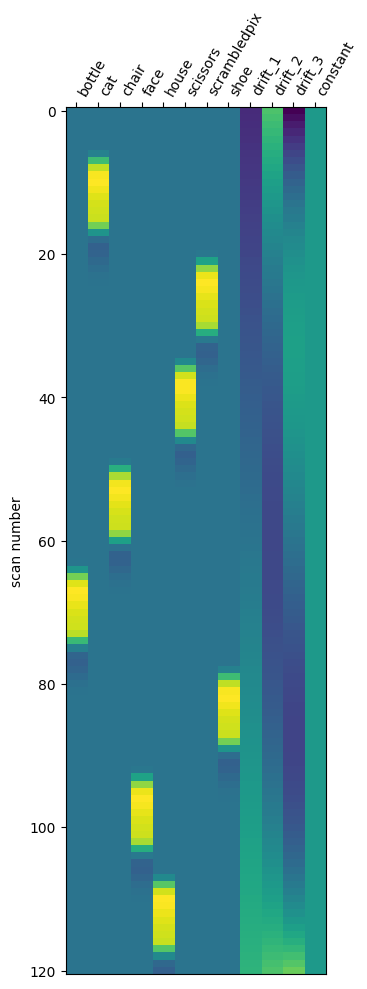

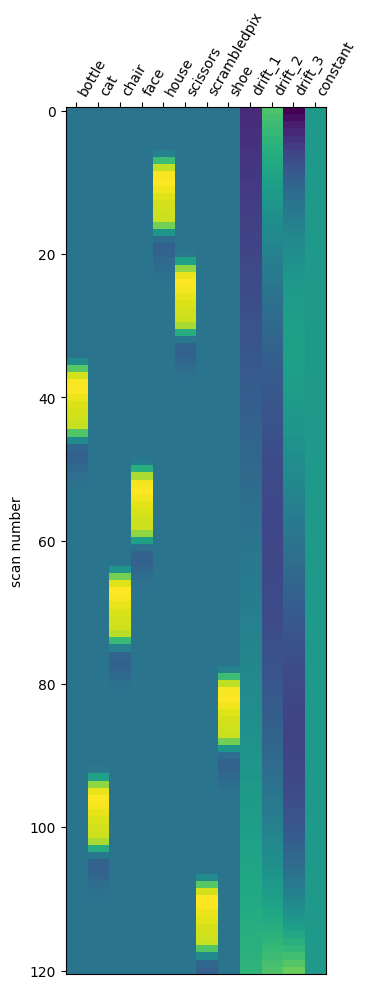

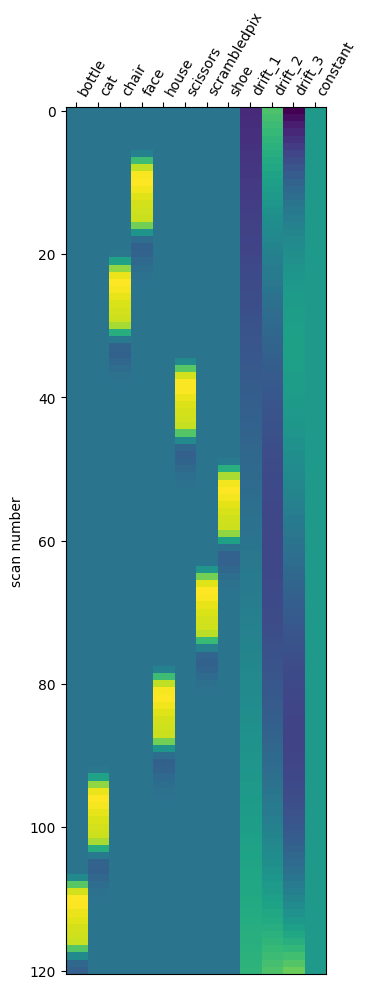

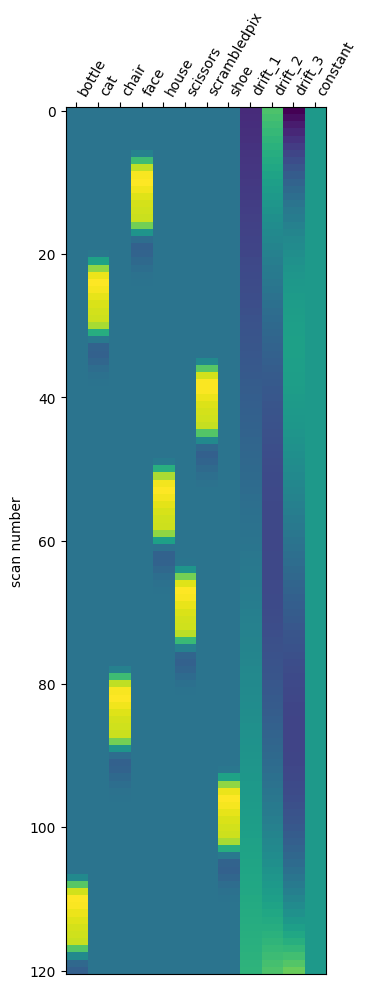

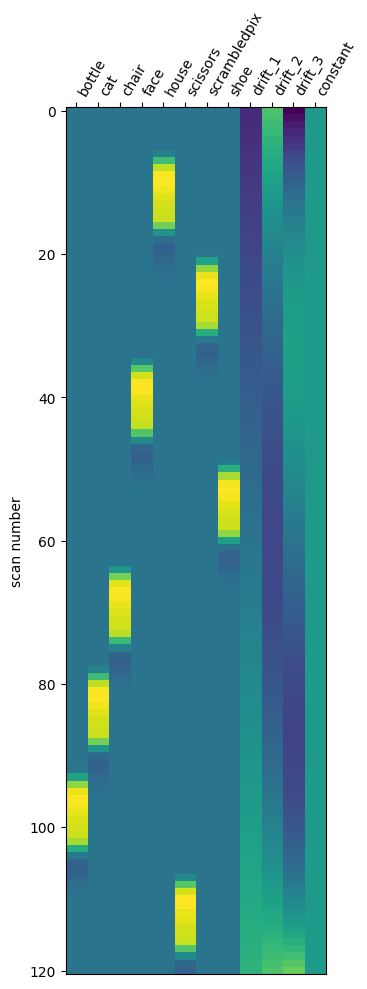

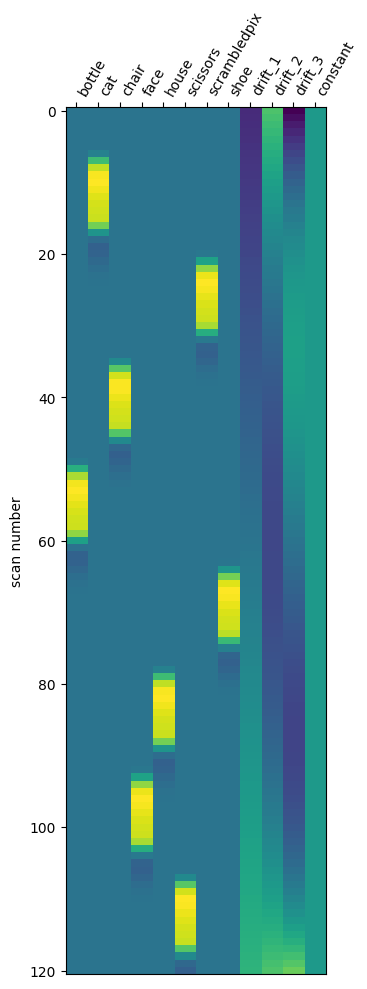

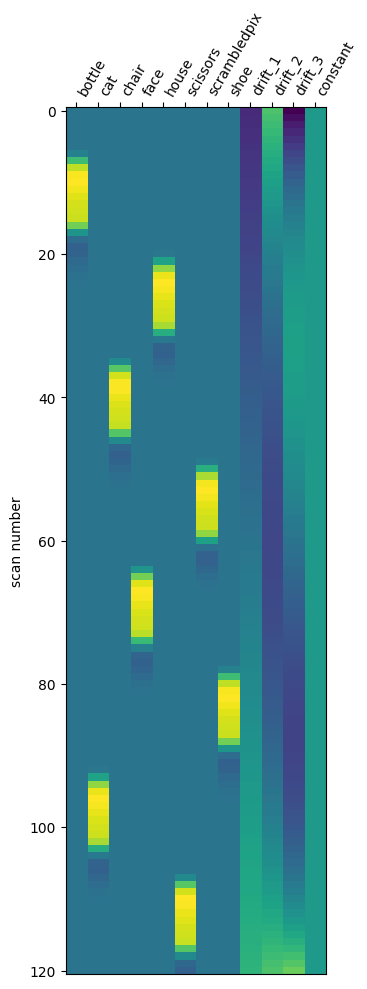

In [ ]:
for matrix_i in fmri_glm.design_matrices_:
    plot_design_matrix(matrix_i)
    plt.show()

### Pause for questions

Please inspect the output in the previous cell. What is going on here?

#### Question 1

What are the columns of these "design matrices"?

#### Question 2

What are the rows of these "design matrices"? What are the "yellow" stripes? How do these relate to the task? Hint: take a look at the stimulus timings and the duration of the stimuli above each plot; also, use the plot_single_column function, as shown below, to inspect each column of the design matrix.

In [ ]:
def plot_single_column(df, col_name):
    """
    Plot a single column of a design matrix as a time-series.

    Parameters
    ----------
    df : a pandas.DataFrame
        A pandas.DataFrame that has been created as a design_matrix_
        from nilearn.
    col_name : a string
        A string indicating the column for plotting.

    Returns
    -------
    out : None
        Returns None but creates a plot via matplotlib.pyplot
    """
    plt.plot(df[col_name])
    plt.title(col_name.capitalize())
    plt.xlabel('Time (s)')
    plt.show()



Here is an example to plot all of the time-series for each column for the first run (i.e., [0]).

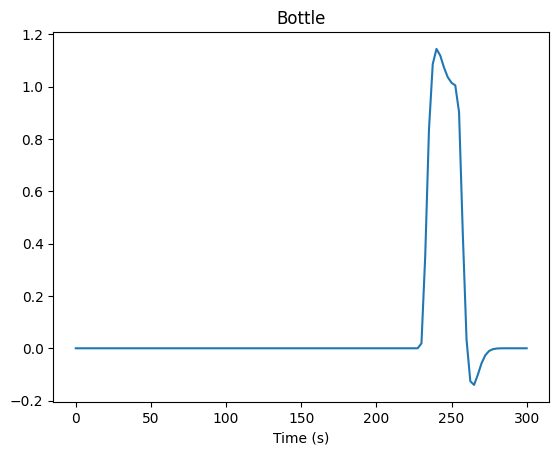

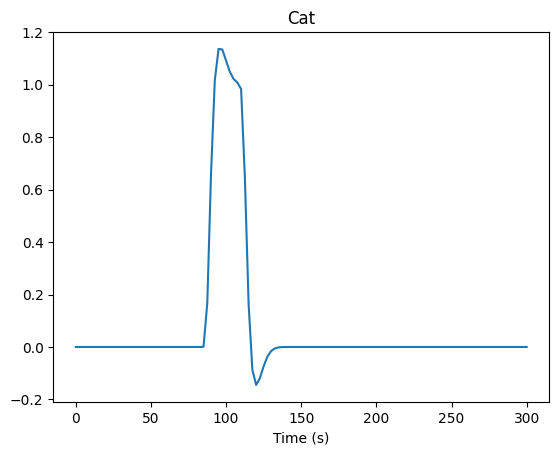

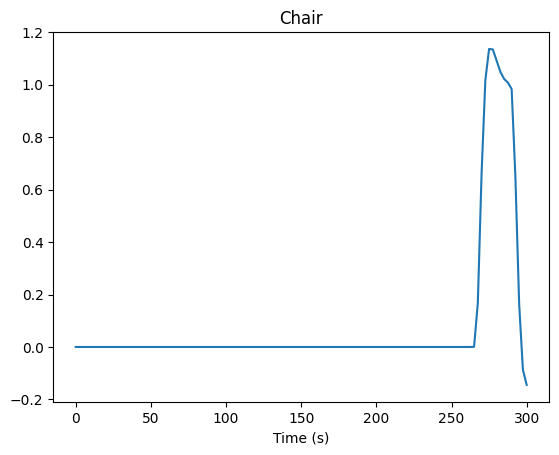

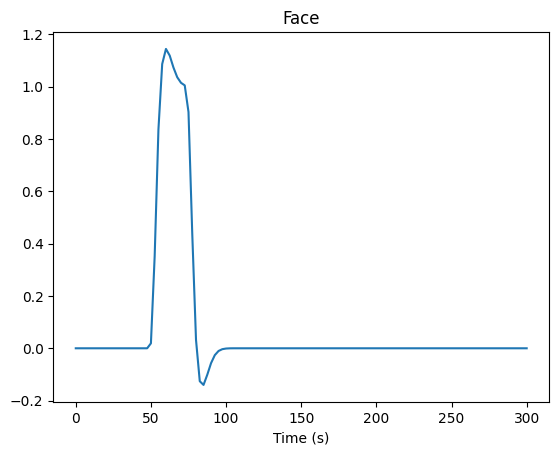

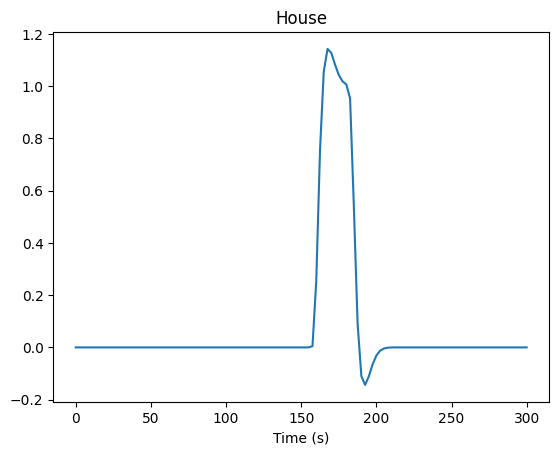

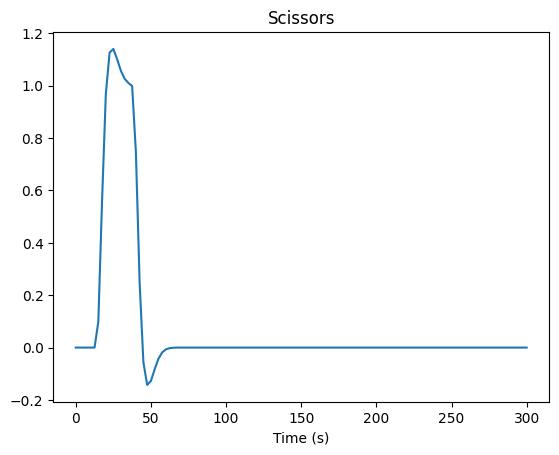

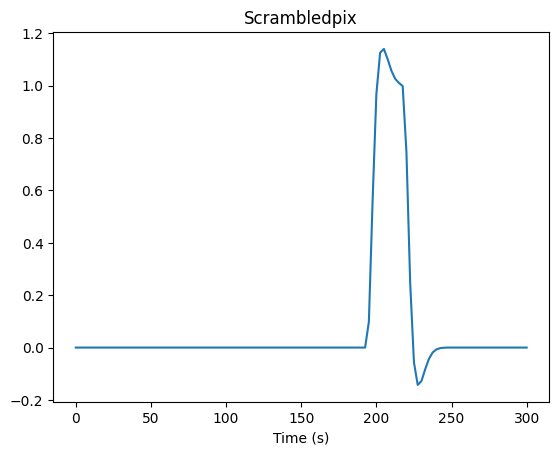

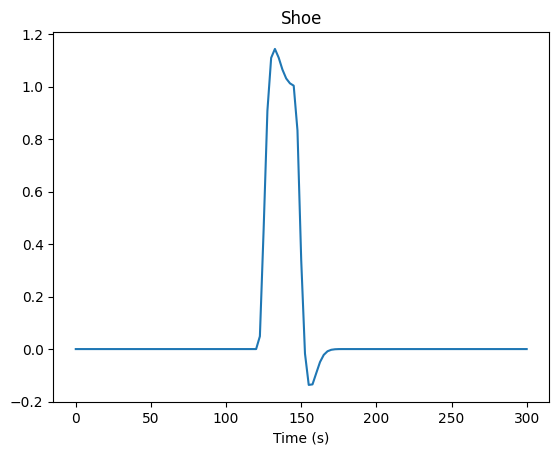

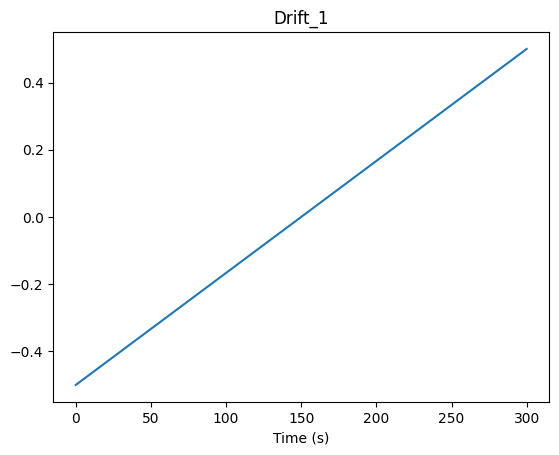

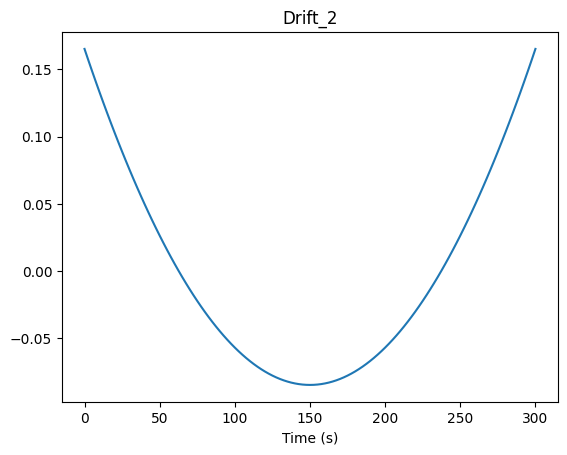

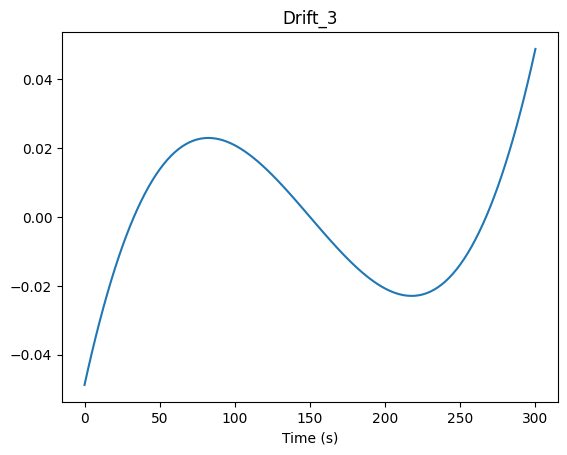

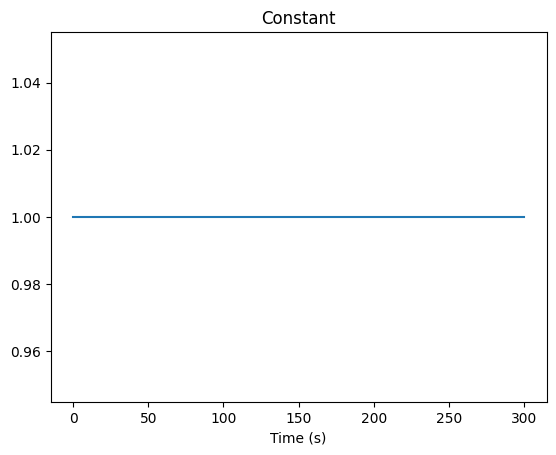

In [ ]:
run_num = 0
curr_matrix = fmri_glm.design_matrices_[run_num]

for col_i in curr_matrix.columns:
    plot_single_column(curr_matrix, col_i)

## We will also want to run some contrasts to compare responses to different categories. We will focus on two categories: faces and houses.

Contrasts will allow us to test specific hypothesis / questions. Here, we will use the *subtraction logic* (Ward, Chapter 4, pg. 63-65) to determine where in the brain voxels have greater BOLD activity for 1) faces vs. other visual stimuli and 2) houses vs. other visual stimuli. This will allow us to replicate findings in the literature that suggest that faces and places (here, houses) might be represented in distinct parts of the brain.

### First, we need to determine which columns of our *design matrix* contain the face and house stimuli.

You can take a look at the ordering of these stimuli as follows (i.e., look at the column names, here from the first run, but they are the same for all runs):

In [ ]:
fmri_glm.design_matrices_[0]

,bottle,cat,chair,face,house,scissors,scrambledpix,shoe,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.500000,0.165278,-0.048757,1.0
2.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.491667,0.157014,-0.043881,1.0
5.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.483333,0.148889,-0.039210,1.0
7.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.475000,0.140903,-0.034741,1.0
10.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.466667,0.133056,-0.030469,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
290.0,0.0,0.0,0.983740,0.0,0.0,0.0,0.0,0.0,0.466667,0.133056,0.030469,1.0
292.5,0.0,0.0,0.647803,0.0,0.0,0.0,0.0,0.0,0.475000,0.140903,0.034741,1.0
295.0,0.0,0.0,0.163338,0.0,0.0,0.0,0.0,0.0,0.483333,0.148889,0.039210,1.0
297.5,0.0,0.0,-0.086818,0.0,0.0,0.0,0.0,0.0,0.491667,0.157014,0.043881,1.0


So, as you can see, the 'face' category is in the 4th column while the 'house' category is in the 5th column.

### Set up and compute contrasts for faces vs. everything and look at the brain maps

#### Set up the contrasts.

We can set up *contrasts* to see where in the brain the face category is more active than all other categories (face > (bottle + cat + chair + face + house + scissors + scrambledpix + shoe)). The contrast is set up such that it sums to zero. In this case, we can set the face column equal to 7 (i.e., the 4th column, as shown above) and the other columns equal to -1 (because 7 + (7 * (-1)) = 0).

Additionally, we have to add a few columns of zeros to this contrast vector. Specifically, here we add zeros for the polynomial drift terms and for the offset (i.e., y intercept) because we do not want to include these in our contrast.

When we run fmri_glm.compute_contrast, we are telling it here to only output the *z score*, which is a statistical measure that will allow us to determine significance (the further the z score is from zero, the lower the p value).

In [ ]:
contrast_face = np.hstack(([-1, -1, -1, 7, -1, -1, -1, -1],
                           np.zeros(poly_drift_order + 1)))

face_zscore = fmri_glm.compute_contrast(contrast_face, output_type='z_score')

/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 12 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


#### Plot the map!

Now, we can create brain maps by *thresholding* our z score map to see which voxels are significantly different than zero. Note: in statistics, you can calculate p values from z scores. Here, the threshold_stats_img will do the work for us and we can set the alpha (i.e., our p value threshold) using the alpha parameter. Note, the height_control='fpr' bit will make it so that it calculates a p value for each voxel. Here, the process of thresholding will create statistical maps where only the voxels that exceed our threshold are shown in our statistical map (i.e., those that were *significantly* different, as determined by the threshold that was calculated for our desired alpha).

In [ ]:
_, threshold = threshold_stats_img(face_zscore, alpha=.001,
                                   height_control='fpr')
print('Uncorrected alpha = 0.001 threshold: %.3f' % threshold)

view = view_img(face_zscore, bg_img=anat, threshold=threshold,
                title='Faces vs. everything', dim=-1, cmap='viridis')
view.save_as_html('faces_stats_0.001uncor.html')

Uncorrected alpha = 0.001 threshold: 3.291


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Now, you can click on the "Files" icon on the left side of this page (it looks likes like a folder) and click on this newly created file (faces_stats_0.001uncor.html) and select "Download". Then, open up your Downloads folder and double-click this file to open it (it should automatically open in a web browser). Note, it might take a second to open up. Once it does, you can click on the images to drag the images around to explore different parts of the brain!

##### The multiple comparisons problem.

Note: this image shows the statistical map that has *not* been corrected for multiple comparisons. However, as we discuss below, we have run many more than one statistical test, which will lead to false positives. We can also run a false-discovery rate (FDR) correction to try to account (somewhat) for false positives (see also Ward, Chapter 4, pg. 74-75).

#### Question 3

Why do we have to correct for multiple comparisons? Please read section below!!

#### Create another map that is FDR corrected for multiple comparisons.

Here, we changed the height_control to 'fdr', which is the false discovery rate (a method of trying to account for multiple comparisons).

In [ ]:
_, threshold = threshold_stats_img(face_zscore, alpha=.001,
                                   height_control='fdr')
print('False Discovery rate = 0.001 threshold: %.3f' % threshold)

view = view_img(face_zscore, bg_img=anat, threshold=threshold,
                title='Faces vs. everything', dim=-1, cmap='viridis')
view.save_as_html('faces_stats_fdr0.001.html')

False Discovery rate = 0.001 threshold: 4.174


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Same idea here. Go ahead and download and then open up the new html file.

#### Question 4

How does this map compare to the other (uncorrected) map? (Hint: you might also want to look at the printed thresholds above to see if you notice a difference.)

### Run the same process for houses vs. everything

#### Set up the contrast.
As mentioned above, the house category is in the 5th column, so now we will set the 5th column equal to 7, the 7 other visual stimuli will be set to -1, and the drift and constant columns will be set to 0.

When we run fmri_glm.compute_contrast, we are telling it here to only output the *z score*, which is a statistical measure that will allow us to determine significance (the further the z score is from zero, the lower the p value).

In [ ]:
contrast_house = np.hstack(([-1, -1, -1, -1, 7, -1, -1, -1],
                            np.zeros(poly_drift_order + 1)))

house_zscore = fmri_glm.compute_contrast(contrast_house, output_type='z_score')

/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 12 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


### Now, we can run the same process to look at the houses vs. everything

#### First up, the uncorrected map.

In [ ]:
_, threshold = threshold_stats_img(house_zscore, alpha=.001,
                                   height_control='fpr')
print('Uncorrected alpha = 0.001 threshold: %.3f' % threshold)

view = view_img(house_zscore, bg_img=anat, threshold=threshold,
                title='Houses vs. everything', dim=-1, cmap='viridis')
view.save_as_html('house_stats_0.001uncor.html')

Uncorrected alpha = 0.001 threshold: 3.291


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Now, you can click on the "Files" icon on the left side of this page (looks like a folder) and download this newly created file (houses_stats_0.001uncor.html) and open it by double-clicking on the file from your Downloads folder.



#### And, of course, the FDR corrected map.

In [ ]:
_, threshold = threshold_stats_img(house_zscore, alpha=.001,
                                   height_control='fdr')
print('False Discovery rate = 0.001 threshold: %.3f' % threshold)

view = view_img(house_zscore, bg_img=anat, threshold=threshold,
                title='Houses vs. everything', dim=-1, cmap='viridis')
view.save_as_html('house_stats_fdr0.001.html')

False Discovery rate = 0.001 threshold: 3.735


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Same idea here. Go ahead and download and then open up the new html file.

#### Question 5

How does this map compare to the other (uncorrected) map? (See also the hint to Question 4)

## Now, please compare these results to an atlas to determine location

This website has a useful tool for looking at an atlas to determine gyri, etc.
https://bioimagesuiteweb.github.io/webapp/mni2tal.html

A couple of things to be aware of when you compare the brain from this analysis to the atlas:

1) The brain from our analysis is *not* in a standard template space but instead is in that partipant's native space. Therefore, you cannot directly compare voxel coordinates.

2) It will help if you click on the box on that website for "show Brodmann areas overlay." It might take a fair bit of clicking around between the atlas and your brain images to get a feeling for the location of activations and of the different gyri in the atlas. For example, make sure that you explore the anterior/posterior extent of each gyrus that might be related to the face activation vs. the house activation.

### Once you have oriented yourself between our analysis and the atlas, please answer the following questions:

#### Question 6

Where is the activation for faces vs. everything else (e.g., the name of the gyrus)? (Hint: the active voxels should be yellow-ish and *not* blue-ish)

#### Question 7

Where is the activation for houses vs. everything else (e.g., the name of the gyrus or gyri)? (Hint: really take a close look at the proximity to the hippocampus in these images)

# What are multiple comparisons and why do we have to correct for them?

In [ ]:
from scipy import stats

Let's simulate 20 trials with 100000 voxels. Here, we will simulate a mean "activity" of 0 (i.e., no difference, loc=0) with a standard deviation of 1 (scale=1)

In [ ]:
rd = np.random.normal(loc=0, scale=1, size=(20, 100000))

Let's gather the t-values and the p-values from these randomly simulated voxels. __Note: In this case, we would not expect any true positives because we are simulating voxels with mean = 0.__

(array([10001.,  9937.,  9988., 10117.,  9894., 10037.,  9875., 10013.,
        10112., 10026.]),
 array([7.98966588e-08, 9.99991479e-02, 1.99998216e-01, 2.99997284e-01,
        3.99996352e-01, 4.99995420e-01, 5.99994488e-01, 6.99993556e-01,
        7.99992624e-01, 8.99991692e-01, 9.99990760e-01]),
 <BarContainer object of 10 artists>)

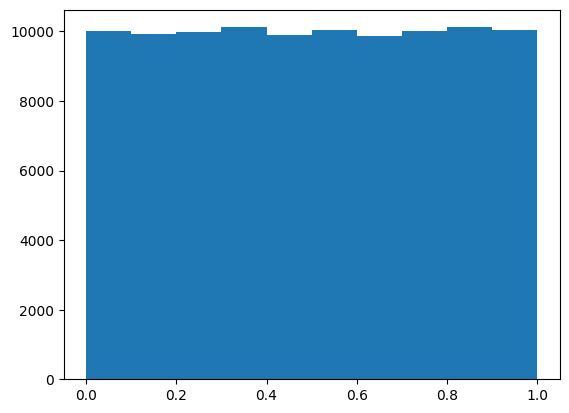

In [ ]:
tval, pval = stats.ttest_1samp(rd, popmean=0, axis=0)

plt.hist(pval)

In [ ]:
len(tval)

100000

However, we see what appears to be a uniform distribution of p-values from 0 to 1.

Let's dig in a little deeper here. What proportion of "voxels" are significant at a given alpha? Let's write a function to find out.

In [ ]:
def calc_prop_sig(x, alpha):
    """
    Calculate the proportion of significant voxels at a given alpha.

    Parameters
    ----------
    x : a 2D numpy.array
        A 2D numpy.array, where each row is an observation/trial and each
        column is a voxel.
    alpha : a float
        A float indicating the alpha / threshold for statistical comparison.

    Returns
    -------
    out : a float
        A float indicating the proportion of significant voxels.
    """
    return np.sum(x < alpha) / len(x)



In [ ]:
print("%f of voxels are significant at alpha=0.05" % calc_prop_sig(pval, 0.05))

print("%f of voxels are significant at alpha=0.01" % calc_prop_sig(pval, 0.01))

0.049840 of voxels are significant at alpha=0.05
0.009940 of voxels are significant at alpha=0.01


## What is happening here?!?!

#### Question 8

How does the above relate to p values? (Hint: What does a p value actually mean?)


### Try making some changes to see if a pattern emerges for other parameters.

##### Try some other alpha levels (e.g., 0.2, 0.1, 0.001).


In [ ]:
print("%f of voxels are significant at alpha=0.2" % calc_prop_sig(pval, 0.2))

print("%f of voxels are significant at alpha=0.1" % calc_prop_sig(pval, 0.1))

print("%f of voxels are significant at alpha=0.001" % calc_prop_sig(pval, 0.001))

0.199380 of voxels are significant at alpha=0.2
0.100010 of voxels are significant at alpha=0.1
0.000950 of voxels are significant at alpha=0.001


#### Question 9

What pattern emerges?

##### Try increasing the number of simulated trials (e.g., 100, 1000).


0.050260 of voxels are significant at alpha=0.05
0.009970 of voxels are significant at alpha=0.01


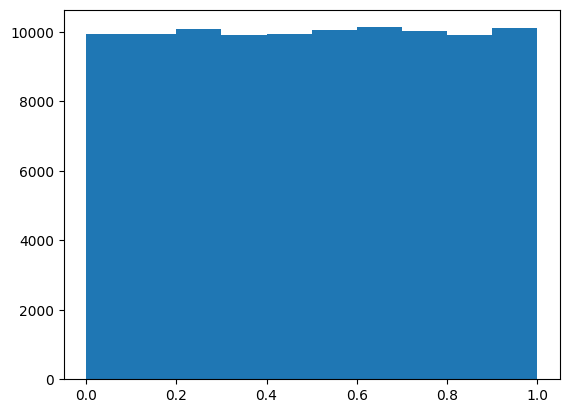

In [ ]:
# INPUT YOUR NEW CODE HERE FOR CHANGING THE NUMBER OF SIMULATED VOXELS

rd = np.random.normal(loc=0, scale=1, size=(1000, 100000))

tval, pval = stats.ttest_1samp(rd, popmean=0, axis=0)

plt.hist(pval)

print("%f of voxels are significant at alpha=0.05" % calc_prop_sig(pval, 0.05))

print("%f of voxels are significant at alpha=0.01" % calc_prop_sig(pval, 0.01))

#### Question 10

Does this (meaningfully) change the proportion of significant voxels?

#### Question 11

Based on what you have done here: are these true or false positives? Hint: what is the rd = np.random.normal(loc=0, scale=1, size=(20, 100000)) call doing (see above and you might also try typing ?np.random.normal into a cell and pressing "Run" so that you can read about this function)?